# Gaussian Processes for Machine Learning

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

plt.style.use('ggplot')

**Baysesian linear model**

- model: 
$$ f(x) = x^T w \quad y = f(x)+ \epsilon $$
$$ \epsilon \sim N(0, \sigma_n^2) $$

- prior
$$ w \sim N(0, \Sigma_p) $$

- likelihood
$$ p(y|X, w) = \prod p(y_i| x_i, w) = N(X^T w, \sigma_n^2 I) $$

- posterior
$$ p(w|X, y) = \frac {p(y|X, w) p(w)}{p(y| X)} $$
$$ p(w|X, y) \sim N(\bar w = \sigma_n^{-2} A^{-1}Xy, A^{-1}),\quad A = \sigma_n^{-2} XX^T+ \Sigma_p^{-1} $$

- prediction
$$ p(f_*| x_*, X, y) = \int p(f_*|x_* w) p(w| X, y) dw  = N(\sigma_n^{-2} x_*^T A^{-1} Xy, x_*^T A^{-1} x_*) $$

[[0.79919679]
 [0.04016064]] [[50.  1.]
 [ 1.  5.]]


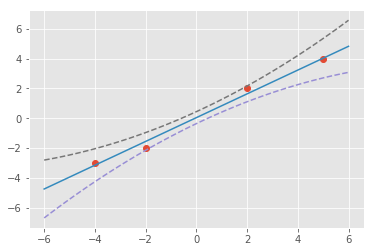

In [79]:
# 2d test
X, y = np.r_[-4, -2, 2, 5], np.c_[[-3, -2, 2, 4]]
X = np.vstack((X, np.ones((1, X.shape[0]))))

sigma_p = np.eye(2)
sigma_n = 1

A = sigma_n**-2* X.dot(X.T)+ la.inv(sigma_p)
invA = la.inv(A)
w_bar = sigma_n**-2* invA.dot(X).dot(y)

print(w_bar, A)

# simple plot
plt.plot(X[0, :], y, 'o')

xs = np.linspace(-6, 6)
ys = xs*w_bar[0, 0]+ w_bar[1, 0]
sigmas = invA[0, 0]* xs* xs+ 2* invA[0, 1]* xs+ invA[1, 1]
plt.plot(xs, ys)
plt.plot(xs, ys- 2* sigmas, '--')
plt.plot(xs, ys+ 2* sigmas, '--')

**Def 2.1** A *Gaussian process* is a *collection of random variables, any finite number of which have a joint Gaussian distribution.*

A Gaussian process is completely specified by its mean function and covariance function. Define mean function $m(x)$, covariance function $k(x, x')$ of a real process $f(x)$ as:
$$ m(x) = E[f(x)] $$
$$ k(x, x') = E[(f(x)- m(x))(f(x')- m(x'))] $$
write Guassian process as:
$$ f(x) \sim \mathcal{GP}(m(x), k(x, x')) $$

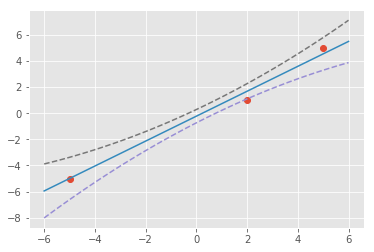

### A.2 Gaussian Identites

**joint probability density**:
$$ p(x|m, \Sigma) = (2\pi)^{-D/2}|\Sigma|^{-1/2} \exp (-\frac 12 (x-m)^T \Sigma^{-1} (x-m)) $$
where $m$ is the mean vector of length $D$, and $\Sigma$ is the symmetric, positive define covariance matrix.

let $x$ and $y$ be jointly Gaussian random vectors
$$ \begin{bmatrix} x \\ y \end{bmatrix} \sim \mathcal N(
\begin{bmatrix} \mu_x \\ \mu_y \end{bmatrix}, 
\begin{bmatrix} A& C \\ C^T & B \end{bmatrix}) = \mathcal N(
\begin{bmatrix} \mu_x \\ \mu_y \end{bmatrix}, 
\begin{bmatrix} \tilde A& \tilde C \\ \tilde C^T & \tilde B \end{bmatrix}^{-1}) $$

then *marginal* distribution of $x$:
$$ x\sim \mathcal N(\mu_x, A) $$
*conditional* distribution of $x$ given $y$:
$$ x|y \sim \mathcal N(\mu_x+ CB^{-1}(y- \mu_y), A- CB^{-1}C^T) = \mathcal N(\mu_x- \tilde A^{-1} \tilde C(y- \mu_y), \tilde A^{-1})$$

the product of two Gaussians gives another(un-normalized) Gaussian:
$$ \mathcal N(x|a, A) \mathcal N(x|b, B) = Z^{-1} \mathcal N(x|c, C) $$
where $c=C(A^{-1}a+ B^{-1}b)$ and $C = (A^{-1}+ B^{-1})^{-1}$

In [34]:
# generate samples x ~ N(m, K) using a scalar Gaussian generator
# let K = LL', then with u ~ N(0, I), x = m+ L*u
# we have mean m, and covariance LE[uu']L' = LL' = K
def gaussian_generator(m, K):
    L = la.decomp_cholesky.cholesky(K)
    def gen():
        u = np.random.randn(m.shape[0])
        return L.dot(u)+ m
    return gen

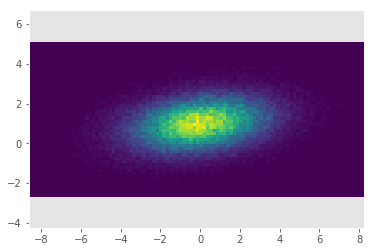

In [61]:
m = np.r_[0, 1]
K = np.c_[[4, 1], [1, 1]]

gen = gaussian_generator(m, K)

xs = np.array([gen() for i in range(100000)])

plt.hist2d(xs[:, 0], xs[:, 1], bins=(100, 50))
re_ = plt.axis('equal')